In [6]:
from rosbag.bag import Bag
from cv_bridge import CvBridge
import matplotlib.pyplot as plt
import cv2
import json
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd, numpy_image_to_torch
from lightglue import viz2d
import torch
import numpy as np
from numba import cuda
import matplotlib

In [3]:
bridge = CvBridge()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)

In [4]:
bag = Bag('2023-10-03-17-10-26.bag', 'r')
bag

In [5]:
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'sensor_msgs/Image': '060021388200f6f0f447d0fcd9c64743', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'std_msgs/String': '992ce8a1687cec8c8bd883ec73ca41d1'}, topics={'/camera/color/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=2168, connections=1, frequency=30.686137367943576), '/camera/imu': TopicTuple(msg_type='sensor_msgs/Imu', message_count=15306, connections=1, frequency=202.75071300816938), '/fusion/matching': TopicTuple(msg_type='sensor_msgs/Image', message_count=134, connections=1, frequency=1.8107392279833479), '/pupil/gaze': TopicTuple(msg_type='std_msgs/String', message_count=10936, connections=1, frequency=167.31705760331897), '/pupil/world': TopicTuple(msg_type='sensor_msgs/Image', message_count=2347, connections=1, frequency=30.59101882443895)})

In [10]:
for index, (topic, msg, t) in enumerate(bag.read_messages()):
    # print(topic, t, index)
    if topic == '/pupil/world':
        world_img = bridge.imgmsg_to_cv2(msg, desired_encoding="rgb8")
    if topic == '/camera/color/image_raw':
        rs_img = bridge.imgmsg_to_cv2(msg, desired_encoding="rgb8")
    if topic == '/pupil/gaze':
        gaze = msg.data.split(',')
    if topic == '/camera/imu':
        pass
    if index == 1200:
        break
    

['717', '391', '1', '1696349431392504320']

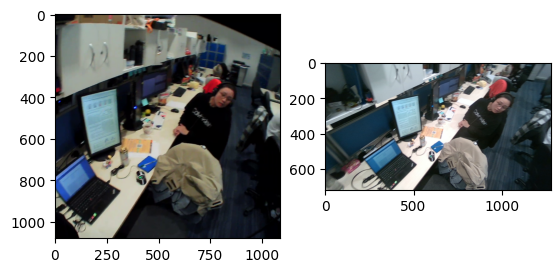

In [11]:
raw_fig, raw_axes = plt.subplots(1,2)
raw_axes[0].imshow(world_img)
raw_axes[1].imshow(rs_img)
gaze

In [8]:
with open("scene_camera.json", "r") as f:
    data = json.load(f)

pupil_camera_matrix = np.array(data["camera_matrix"])
pupil_dist_coeffs = np.array(data["dist_coefs"])

with open("realsense_camera.json", "r") as f:
    data = json.load(f)

rs_camera_matrix = np.array(data["camera_matrix"])
rs_dist_coeffs = np.array(data["dist_coefs"])

array([[[722.88416, 386.88373]]], dtype=float32)

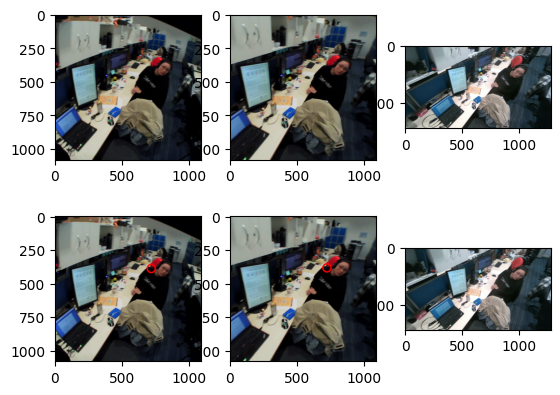

In [13]:
undistorted_fig, undistorted_axes = plt.subplots(2,3)
undistorted_world_img = cv2.undistort(world_img, pupil_camera_matrix, pupil_dist_coeffs)
undistorted_rs_img = cv2.undistort(rs_img, rs_camera_matrix, rs_dist_coeffs)

src_gaze = np.array([np.matrix([int(gaze[0]), int(gaze[1])]).transpose()], dtype="float32")
undistorted_gaze = cv2.undistortPoints(src_gaze, pupil_camera_matrix, pupil_dist_coeffs, P=pupil_camera_matrix)

circled_world_img = cv2.circle(world_img.copy(), [int(gaze[0]), int(gaze[1])], 30, (255, 0, 0), 10)
circled_undistorted_world_img = cv2.circle(undistorted_world_img.copy(), [int(undistorted_gaze[0][0][0]), int(undistorted_gaze[0][0][1])], 30, (255, 0, 0), 10)

undistorted_axes[0][0].imshow(world_img)
undistorted_axes[0][1].imshow(undistorted_world_img)
undistorted_axes[0][2].imshow(rs_img)
undistorted_axes[1][0].imshow(circled_world_img)
undistorted_axes[1][1].imshow(circled_undistorted_world_img)
undistorted_axes[1][2].imshow(undistorted_rs_img)
undistorted_gaze

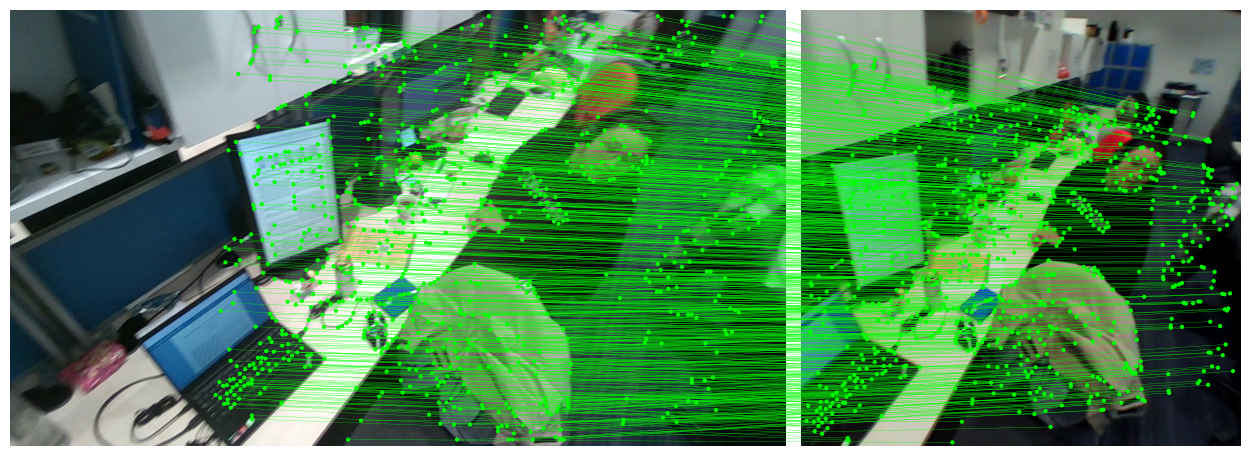

In [14]:
image0 = numpy_image_to_torch(undistorted_rs_img.copy())
image1 = numpy_image_to_torch(undistorted_world_img.copy())
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
# fig = plt.gcf()

# lightglue(rs_img, undistorted_world_img)

In [15]:
c_m_kpts0 = m_kpts0.cpu().numpy()
c_m_kpts0

array([[ 790.125,   10.125],
       [ 913.875,   10.125],
       [1068.875,   10.125],
       ...,
       [ 862.625,  708.875],
       [ 907.625,  708.875],
       [ 913.875,  708.875]], dtype=float32)

In [16]:
c_m_kpts1 = m_kpts1.cpu().numpy()
c_m_kpts1

array([[550.40625, 233.88976],
       [674.71875, 241.3307 ],
       [829.84375, 232.82677],
       ...,
       [792.65625, 972.66925],
       [844.71875, 965.22833],
       [850.03125, 968.4173 ]], dtype=float32)

[746.3203  437.88763] ['717', '391', '1', '1696349431392504320']


array([550.40625, 233.88976], dtype=float32)

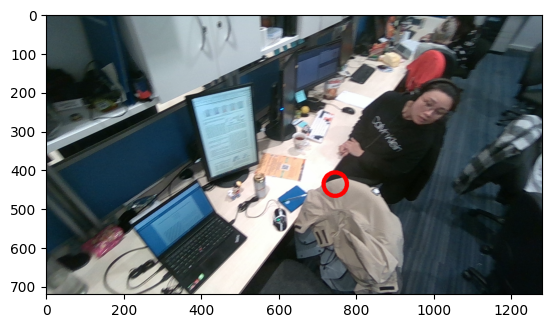

In [17]:
c_m_kpts1.transpose()
p0_p1t = np.matmul(c_m_kpts0.transpose(), c_m_kpts1)
p0_p1t
p1_p1t = np.linalg.inv(np.matmul(c_m_kpts1.transpose(), c_m_kpts1))
p1_p1t
# ppt_1 = np.linalg.inv(ppt)
H = np.matmul(p0_p1t, p1_p1t)
gaze_mat = np.array([gaze[0], gaze[1]], dtype='float32')
t_gaze = np.matmul(gaze_mat, H)
print(t_gaze, gaze)
circled_t_rs_img = cv2.circle(rs_img.copy(), [int(t_gaze[0]), int(t_gaze[1])], 30, (255, 0, 0), 10)
plt.imshow(circled_t_rs_img)
c_m_kpts1[0]
# gaze_mat

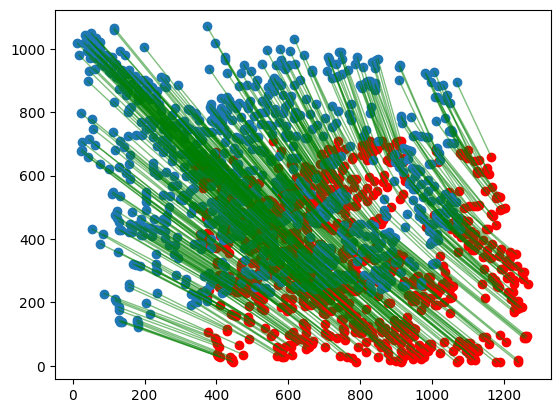

In [18]:
lw=1
ps=4
a=0.5
fig, ax = plt.subplots()
ax.scatter(c_m_kpts0[:, 0], c_m_kpts0[:, 1], color='red')
ax.scatter(c_m_kpts1[:, 0], c_m_kpts1[:, 1])
for i in range(len(c_m_kpts0)):
    line = matplotlib.patches.ConnectionPatch(
        xyA=(c_m_kpts0[i, 0], c_m_kpts0[i, 1]), xyB=(c_m_kpts1[i, 0], c_m_kpts1[i, 1]),
        coordsA=ax.transData, coordsB=ax.transData,
        axesA=ax, axesB=ax,
        zorder=1, color='green', linewidth=lw, clip_on=True,
        alpha=a,
        picker=5.0)
    line.set_annotation_clip(True)
    fig.add_artist(line)
plt.savefig('optical flow.png')
plt.show()

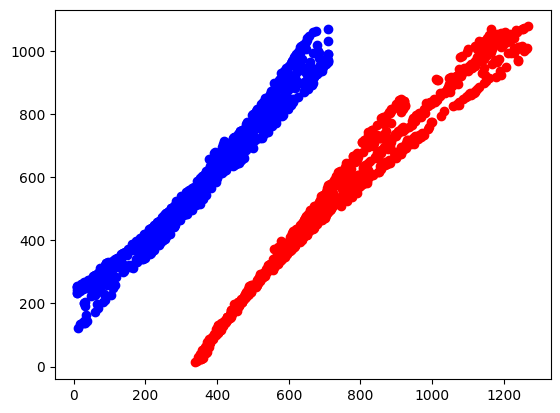

In [19]:
fig, ax = plt.subplots()
ax.scatter(c_m_kpts0[:, 0], c_m_kpts1[:, 0], color='red')
ax.scatter(c_m_kpts0[:, 1], c_m_kpts1[:, 1], color='blue')
plt.show()

In [20]:
xa, xb = np.polyfit(c_m_kpts0[:, 0], c_m_kpts1[:, 0], 1)
xa, xb

(1.1357253835527272, -307.5387187382884)

In [21]:
ya, yb = np.polyfit(c_m_kpts0[:, 1], c_m_kpts1[:, 1], 1)
ya, yb

(1.1741615222751827, 170.7909862369798)

In [22]:
xg, yg = int(gaze[0]), int(gaze[1])
xg, yg

(717, 391)

In [23]:
xg1 = (xg - xb) / xa
yg1 = (yg - yb) / ya
xg1, yg1

(902.1007486276045, 187.5457588972251)

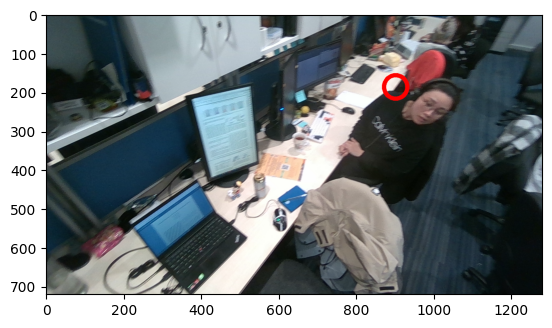

In [24]:
circled_t_rs_img = cv2.circle(rs_img.copy(), [int(xg1), int(yg1)], 30, (255, 0, 0), 10)
plt.imshow(circled_t_rs_img)

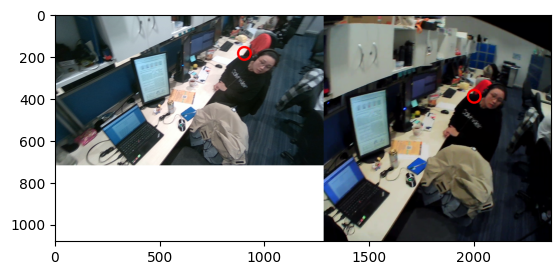

In [30]:
rs_out = np.ones((1080,1280,3),dtype=np.uint8)*255
world_out = np.ones((1080,1088,3),dtype=np.uint8)*255

rs_out[:720,:1280,:] = circled_t_rs_img[:,:,:]
world_out[:1080,:1088,:] = circled_world_img[:,:,:]
results = np.concatenate((rs_out, world_out), axis=1)
plt.imshow(results)